## ИНИЦИАЛИЗАЦИЯ СРЕДЫ ##

In [1]:
# переменные для управления ходом выполнения ячеек

INFER_MODE = True      # True для включения режима расчета inference-рекомендаций

CALC_ALS   = True      # True для пересчета и сохранения als_model; 
                        # False - для загрузки сохраненной als_model
CALC_RECS  = True      # True для пересчета и сохранения personal_als, similarity и top_popular;
                        # False - для загрузки сохраненных personal_als, similarity и top_popular

ALS_GRID   = False      # True для подбора гиперпараметров ALS (~ 1 час)
CB_GRID    = False      # True для подбора гиперпараметров Catboost (только при INFER_MODE==False)

if CB_GRID and INFER_MODE: raise(Exception("Неверная комбинация параметров управления"))

> <ins>**ВАЖНО**</ins>: \
> Перед запуском данного Notebook необходимо запустить сервер MLFlow !

In [2]:
# код для условного выполнения ячеек, начинающихся с %%exec_if <condition>
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
@register_cell_magic
def exec_if(line, cell):
    try:
        if eval(line): get_ipython().run_cell(cell)
    except:
        pass
    return
   

In [3]:
# Инициализируем окружение
import os, joblib, s3fs
import pandas as pd
import numpy  as np

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100 

from dotenv import load_dotenv, find_dotenv, dotenv_values
load_dotenv(find_dotenv("env.services"))

PROJECT_ROOT     = f"{find_dotenv()[0:-5]}"
DATA_DIR         = f"{PROJECT_ROOT}/data"
MODEL_NAME       = os.environ['MLFLOW_MODEL_NAME']
EXPERIMENT_NAME  = os.environ['MLFLOW_EXPERIMENT_NAME']
MLFLOW_SERVER_URL= f"http://localhost:{os.environ['MLFLOW_SERVER_PORT']}"
RANDOM_STATE     = 42
SECRETS          = dotenv_values()                        # НЕ загружаем credentials в переменные окружения
S3_DIR           = f"{SECRETS['S3_BUCKET_NAME']}/Diplom"

s3 = s3fs.core.S3FileSystem(
    endpoint_url=SECRETS['AWS_ENDPOINT_URL'],
    key         =SECRETS['AWS_ACCESS_KEY_ID'],
    secret      =SECRETS['AWS_SECRET_ACCESS_KEY'], cache_regions=True
)

# перенаправление вывода logging в notebook
import logging
logging.basicConfig(level=logging.INFO, format='%(message)s', force=True)


## ОБЗОР И ПРЕДОБРАБОТКА ДАННЫХ ##

In [4]:
# загружаем лес категорий
with s3.open(f"{S3_DIR}/data/category_tree.csv", mode='r') as fd:
    ctree = pd.read_csv(fd)
ctree.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [5]:
# смотрим диапазоны значений
ctree.describe()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


In [6]:
# преобразуем parentid у корневых категорий
ctree['parentid'] = ctree['parentid'].fillna(-1).astype('int')

# убеждаемся, что деревья категорий не пересекаются и не дублируются (ровно 1 родитель у каждого узла)
ctree.groupby('categoryid').agg(parents=('parentid','count')).max()

parents    1
dtype: int64

In [7]:
# убеждаемся в отсутствии некорректных parentid
ctree.query("parentid not in @ctree['categoryid'].unique()").shape[0] == ctree.query("parentid == -1").shape[0]

True

In [8]:
# определяем корневую категорию и глубину вложенности для каждого узла
def get_ctree_root(id, verbose=False):
    nodelist = [id]
    while True:
        nodelist += [ ctree.at[nodelist[-1], 'parentid'] ]
        if nodelist[-1] == -1: break
    if verbose: print(nodelist)
    return nodelist[-2], len(nodelist) -1
vec_ctree_root = np.vectorize(get_ctree_root)

ctree.set_index('categoryid', inplace=True)
ctree['root'], ctree['depth'] = vec_ctree_root(ctree.index.values)
ctree.reset_index(inplace=True)
ctree.head()

,categoryid,parentid,root,depth
0,1016,213,1532,4
1,809,169,395,4
2,570,9,653,4
3,1691,885,1579,3
4,536,1691,1579,4


In [9]:
ctree.nunique()

categoryid    1669
parentid       363
root            25
depth            6
dtype: int64

In [10]:
ctree['depth'].value_counts()

depth
3    702
4    665
2    174
5     90
1     25
6     13
Name: count, dtype: int64

In [11]:
# статистика по деревьям категорий
ctree.groupby('root').agg(
    treesize=('categoryid','count'), depth=('depth','max')
).sort_values(by='treesize', ascending=False)

,treesize,depth
root,,
140,290,6
1600,187,6
653,154,4
1579,135,4
1532,130,6
395,120,5
1482,101,4
250,97,4
1224,70,4


In [12]:
# загружаем каталог товаров
with s3.open(f"{S3_DIR}/data/item_properties_part1.csv", mode='r') as fd:
    item1 = pd.read_csv(fd)
item1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype 
---  ------     --------------     ----- 
 0   timestamp  10999999 non-null  int64 
 1   itemid     10999999 non-null  int64 
 2   property   10999999 non-null  object
 3   value      10999999 non-null  object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [13]:
# загружаем каталог товаров - часть2
with s3.open(f"{S3_DIR}/data/item_properties_part2.csv", mode='r') as fd:
    item2 = pd.read_csv(fd)
item2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   timestamp  9275903 non-null  int64 
 1   itemid     9275903 non-null  int64 
 2   property   9275903 non-null  object
 3   value      9275903 non-null  object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


In [14]:
# количество уникальных значений timestamp в 1-ой и 2-ой частях
item1['timestamp'].nunique(), item2['timestamp'].nunique()

(18, 18)

In [15]:
# выясняем, что части 1 и 2 каталога формируются в одно время
set(item1['timestamp'].unique()) - set(item2['timestamp'].unique())

set()

In [16]:
# время первого и последнего формирования каталога в датасете
pd.to_datetime(item1['timestamp'].min(), unit='ms'), pd.to_datetime(item1['timestamp'].max(), unit='ms')

(Timestamp('2015-05-10 03:00:00'), Timestamp('2015-09-13 03:00:00'))

In [17]:
# выясняем, что 1-я и 2-я части item_properties относятся к одним и тем же items
print(item1['itemid'].nunique(), item2['itemid'].nunique())
set(item1['itemid'].unique()) - set(item2['itemid'].unique())

417053 417053


set()

In [18]:
# объединяем обе части
items = pd.concat([item1, item2], axis=0, ignore_index=True)
items.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype 
---  ------     --------------     ----- 
 0   timestamp  20275902 non-null  int64 
 1   itemid     20275902 non-null  int64 
 2   property   20275902 non-null  object
 3   value      20275902 non-null  object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


In [19]:
items.nunique()

timestamp         18
itemid        417053
property        1104
value        1966868
dtype: int64

In [20]:
# статистика загрузок
items.groupby(pd.to_datetime(items['timestamp'], unit='ms')).agg(
    items=('itemid','count'), dist_items=('itemid','nunique'), dist_props=('property','nunique'), dist_vals=('value','nunique')
)

,items,dist_items,dist_props,dist_vals
timestamp,,,,
2015-05-10 03:00:00,3012756,399294,459,941110
2015-05-17 03:00:00,1027889,345391,973,276746
2015-05-24 03:00:00,1815598,390648,1036,293292
2015-05-31 03:00:00,2620101,399860,1044,500700
2015-06-07 03:00:00,1686681,393289,1036,309722
2015-06-14 03:00:00,755965,308127,966,188042
2015-06-28 03:00:00,2368972,403277,1054,495262
2015-07-05 03:00:00,497785,232021,469,150245
2015-07-12 03:00:00,593657,250021,840,167956


In [21]:
# сдвигаем начало "операционного дня" к началу календарных суток
TIMELAG = 3*3600*1000
items['timestamp'] = items['timestamp'] - TIMELAG

In [22]:
# убеждаемся, что внутри каждой загрузки properties каждого объекта уникальны
items.groupby(['timestamp','itemid']).agg(
    props=('property','count'), dist_props=('property','nunique')
).query("dist_props < props").shape[0]

0

In [23]:
# смотрим содержимое колонки properties
items['property'].value_counts()


property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
               ...   
472                 1
634                 1
57                  1
1091                1
769                 1
Name: count, Length: 1104, dtype: int64

In [24]:
# смотрим, какие значения может принимать 'available'
items.query("property == 'available'")['value'].value_counts()

value
0    863086
1    640553
Name: count, dtype: int64

In [25]:
# смотрим статистику значений атрибута 'available' в разрезе товаров
itemav = items.query("property == 'available'").groupby('itemid').agg(vals=('value','count'),dist_vals=('value','nunique'))
itemav.shape, itemav['vals'].min(), itemav['vals'].max(), itemav['dist_vals'].min(), itemav['dist_vals'].max()

((417053, 2), 1, 18, 1, 2)

In [26]:
# смотрим статистику значений атрибута 'categoryid' в разрезе товаров
itemcat = items.query("property == 'categoryid'").groupby('itemid').agg(vals=('value','count'),dist_vals=('value','nunique'))
itemcat.shape, itemcat['vals'].min(), itemcat['vals'].max(), itemcat['dist_vals'].min(), itemcat['dist_vals'].max()

((417053, 2), 1, 18, 1, 4)

In [27]:
# топ товаров с изменяющейся категорией
itemcat.sort_values(by='dist_vals', ascending=False).head()

,vals,dist_vals
itemid,,
310572,13,4
3590,18,4
62122,13,4
5070,18,4
302562,18,4


In [28]:
# пример товара с изменяющейся категорией
items.query("property == 'categoryid' and itemid==5070").sort_values(by='timestamp').merge(
    ctree[['categoryid','root']].astype(str), how='left', left_on='value', right_on='categoryid'
)

,timestamp,itemid,property,value,categoryid,root
0,1431216000000,5070,categoryid,1167,1167,250
1,1431820800000,5070,categoryid,1167,1167,250
2,1432425600000,5070,categoryid,1167,1167,250
3,1433030400000,5070,categoryid,1167,1167,250
4,1433635200000,5070,categoryid,1167,1167,250
5,1434240000000,5070,categoryid,1167,1167,250
6,1435449600000,5070,categoryid,1167,1167,250
7,1436054400000,5070,categoryid,519,519,1452
8,1436659200000,5070,categoryid,519,519,1452
9,1437264000000,5070,categoryid,176,176,395


In [29]:
# определяем itemid товаров, категории которых отсутствуют в ctree
bad_itemids = set(
    items.query("property == 'categoryid'").sort_values(by='timestamp').merge(
        ctree[['categoryid']].astype(str), how='left', left_on='value', right_on='categoryid'
    ).query("categoryid.isna()")['itemid']
)
len(bad_itemids)

137

In [30]:
# удаляем записи о товарах с некорректными categoryid
items.query("itemid not in @bad_itemids", inplace=True)
items.shape

(20271942, 4)

In [31]:
# выделяем записи categoryid и available в отдельнуые таблицы
items_ctgr = items.query("property == 'categoryid'").sort_values(
    ['timestamp','itemid'], ascending=[False,True], ignore_index=True
).drop(columns='property').rename(columns={'value':'categoryid'})
items_ctgr['categoryid'] = items_ctgr['categoryid'].astype(int)

items_avail= items.query("property == 'available'").sort_values(
    ['timestamp','itemid'], ascending=[False,True], ignore_index=True
).drop(columns='property')
items_ctgr.shape, items_avail.shape

((788013, 3), (1503502, 3))

In [32]:
# удаляем записи categoryid и available из item_properties
items.query("property != 'available'  and  property != 'categoryid'", inplace=True)
items.shape

(17980427, 4)

In [33]:
# заменяем уникальные значения property-value числовым кодом
items['value_code'] = (
    items.sort_values(by=['property','value']).groupby('property')['value'].transform('rank',method='dense').astype(int)
)
items.head()

,timestamp,itemid,property,value,value_code
1,1441497600000,206783,888,1116713 960601 n277.200,42817
2,1439078400000,395014,400,n552.000 639502 n720.000 424566,891
3,1431216000000,59481,790,n15360.000,6759
4,1431820800000,156781,917,828513,271855
6,1434240000000,89534,213,1121373,1


In [34]:
# характеристики properties
props = items.groupby('property').agg(items=('itemid','count'), values=('value_code','max')).reset_index()
props.head()

,property,items,values
0,0,41406,859
1,1,5649,3
2,10,468,3
3,100,244,15
4,1000,2853,3


In [35]:
# исследуем целесообразность выделения категориальных properties
props.query("values <= 10").groupby('values').agg(
    n_props=('property','count'), n_items_from=('items','min'), n_items_to=('items','max')
)


,n_props,n_items_from,n_items_to
values,,,
1,97,1,416916
2,121,2,17258
3,89,3,54141
4,71,4,20094
5,49,5,29033
6,46,14,54141
7,25,10,11536
8,44,14,37100
9,38,28,239372


In [36]:
# выделяем категориальные признаки, присущие ограниченному количеству товаров (n_items_to)
categorical_props = props.query("values >1 and values <9")['property'].astype(int).unique()
categorical_props.shape

(445,)

In [37]:
# преобразуем содержимое таблицы в целые числа
items = items.drop(columns=['value']).astype(int).sort_values(
    ['timestamp','itemid','property'], ascending=[False,True,True], ignore_index=True
)
items.head()

,timestamp,itemid,property,value_code
0,1442102400000,0,6,3711
1,1442102400000,1,790,25706
2,1442102400000,1,888,150746
3,1442102400000,3,283,77707
4,1442102400000,4,591,1


In [38]:
del item1, item2
items.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17980427 entries, 0 to 17980426
Data columns (total 4 columns):
 #   Column      Non-Null Count     Dtype
---  ------      --------------     -----
 0   timestamp   17980427 non-null  int64
 1   itemid      17980427 non-null  int64
 2   property    17980427 non-null  int64
 3   value_code  17980427 non-null  int64
dtypes: int64(4)
memory usage: 548.7 MB


In [39]:
# определяем процедуры для извлечения item properties

def get_registered_items(timestamp):
    ''' Возвращает набор itemid, для которых определена корректная категория на заданный момент времени '''
    return  set(items_ctgr.query("timestamp <= @timestamp")['itemid'])

def get_unavailable_items(timestamp):
    ''' Возвращает набор itemid, для которых установлен признак available==0 на заданный момент времени '''
    tmp = items_avail.query("timestamp <= @timestamp").drop_duplicates(subset=['itemid'], keep='first')
    return  set(tmp.query("value == '0'")['itemid'])

def get_available_items(timestamp):
    ''' Возвращает набор itemid, доступных на заданный момент времени '''
    return  get_registered_items(timestamp) - get_unavailable_items(timestamp)

def get_item_availability(timestamp):
    ''' Возвращает признак доступности товаров, актуальный на заданный момент времени '''
    lst = get_registered_items(timestamp)
    tmp = items_avail.query("timestamp <= @timestamp and itemid in @lst") \
                     .drop_duplicates(subset=['itemid'], keep='first').reset_index(drop=True)
    return  tmp[['itemid','value']]

def get_item_category(timestamp, itemid=None):
    ''' Возвращает категории товаров/товара, актуальные на заданный момент времени '''
    tmp = items_ctgr.query("timestamp <= @timestamp") \
                    .drop_duplicates(subset=['itemid'], keep='first').reset_index(drop=True)
    return  tmp[['itemid','categoryid']] if itemid is None  else  tmp.query("itemid == @itemid")['categoryid'].value

def get_item_properties(timestamp, itemid=None):
    ''' Возвращает свойства товаров/товара, актуальные на заданный момент времени '''
    tmp = items.query("timestamp <= @timestamp") \
               .drop_duplicates(subset=['itemid','property'], keep='first').reset_index(drop=True)
    return  tmp[['itemid','property','value_code']] if itemid is None  \
      else  tmp.query("itemid == @itemid")[['property','value_code']]


In [40]:
# зарегистрированные (присвоена категория), недоступные и доступные товары по результатам загрузок
for load_date in np.sort(items['timestamp'].unique()):
    print(pd.to_datetime(load_date, unit='ms'), len(get_registered_items(load_date)),
          len(get_unavailable_items(load_date)), len(get_available_items(load_date))
    )

2015-05-10 00:00:00 214452 183484 117274
2015-05-17 00:00:00 239060 203487 119450
2015-05-24 00:00:00 254749 225695 112683
2015-05-31 00:00:00 317864 281520 94249
2015-06-07 00:00:00 337646 293380 91897
2015-06-14 00:00:00 340767 290261 95838
2015-06-28 00:00:00 404357 354422 51493
2015-07-05 00:00:00 404539 346213 59097
2015-07-12 00:00:00 405848 349116 57631
2015-07-19 00:00:00 407224 353100 55240
2015-07-26 00:00:00 407632 351466 57199
2015-08-02 00:00:00 408030 351683 57330
2015-08-09 00:00:00 408785 354058 55771
2015-08-16 00:00:00 411670 356957 55180
2015-08-23 00:00:00 412906 358822 54339
2015-08-30 00:00:00 413607 362553 51309
2015-09-06 00:00:00 414988 363129 52072
2015-09-13 00:00:00 416916 362906 54010


> ***ВАЖНОЕ НАБЛЮДЕНИЕ:*** \
> Суммарное количество доступных и недоступных items почти всегд превышает количество товаров,
> которым присвоена категория. \
> Это означает, что признак доступности может загружаться ДО присвоения товару категории

In [41]:
# загружаем события
with s3.open(f"{S3_DIR}/data/events.csv", mode='r') as fd:
    events = pd.read_csv(fd)
events.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      2756101 non-null  int64  
 1   visitorid      2756101 non-null  int64  
 2   event          2756101 non-null  object 
 3   itemid         2756101 non-null  int64  
 4   transactionid  22457 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [42]:
# сдвигаем начало "операционного дня" к началу календарных суток
events['timestamp'] = events['timestamp'] - TIMELAG

# диапазон дат событий
pd.to_datetime(events['timestamp'].min(), unit='ms'), pd.to_datetime(events['timestamp'].max(), unit='ms')

(Timestamp('2015-05-03 00:00:04.384000'),
 Timestamp('2015-09-17 23:59:47.788000'))

In [43]:
# изначальное количество уникальных пользователей, товаров и транзакций...
events.nunique()

timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64

In [44]:
# дисбаланс операций
events['event'].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [45]:
# убираем события с объектами, категории которых не зарегистрированы в ctree
events.query("itemid in @items_ctgr['itemid'].unique()", inplace=True)

# кодируем значения в колонке event
events['event'] = events['event'].replace({'view':'0', 'addtocart':'1', 'transaction':'2'}).astype(int)
events['event'].value_counts()

event
0    2410035
1      68499
2      21982
Name: count, dtype: int64

In [46]:
# удаляем события, произошедшие до регистрации категорий соответствующих items
# и, заодно, определяем актуальную категорию товара для каждого события

events.sort_values(by='timestamp', inplace=True)
evtmp = events.query("timestamp < @events['timestamp'].min()")    # инициализируем временный dataframe
prev_date = 0

for load_date in sorted(items['timestamp'].unique().tolist() + [events['timestamp'].max()+1]):
    valid_items = get_registered_items(load_date-1)
    events.query("timestamp >= @load_date or itemid in @valid_items", inplace=True)  # удаление незарегистрированных
    #'''
    evtmp = pd.concat([
        evtmp,
        events.query("timestamp < @load_date and timestamp >= @prev_date").merge(
            get_item_category(load_date-1), how='left', on='itemid'                  # получение актуальной категории
        ).merge(
            get_item_availability(load_date-1), how='left', on='itemid'              # получение актуальной доступности
        )
    ], axis=0, ignore_index=True)
    #'''
    prev_date = load_date
    print(load_date, pd.to_datetime(load_date, unit='ms'), events.shape[0], evtmp.shape[0])


1431216000000 2015-05-10 00:00:00 2375843 0
1431820800000 2015-05-17 00:00:00 2318204 71585
1432425600000 2015-05-24 00:00:00 2261831 156316
1433030400000 2015-05-31 00:00:00 2215618 239517
1433635200000 2015-06-07 00:00:00 2188277 346085
1434240000000 2015-06-14 00:00:00 2168674 446159
1435449600000 2015-06-28 00:00:00 2125640 664218
1436054400000 2015-07-05 00:00:00 2123785 789840
1436659200000 2015-07-12 00:00:00 2121183 930025
1437264000000 2015-07-19 00:00:00 2119411 1068329
1437868800000 2015-07-26 00:00:00 2116784 1213727
1438473600000 2015-08-02 00:00:00 2113502 1357185
1439078400000 2015-08-09 00:00:00 2109576 1470706
1439683200000 2015-08-16 00:00:00 2106727 1574921
1440288000000 2015-08-23 00:00:00 2104996 1688694
1440892800000 2015-08-30 00:00:00 2103361 1800691
1441497600000 2015-09-06 00:00:00 2101486 1907610
1442102400000 2015-09-13 00:00:00 2099173 2028594
1442534387789 2015-09-17 23:59:47.789000 2099173 2099173


In [47]:
evtmp.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099173 entries, 0 to 2099172
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      2099173 non-null  int64  
 1   visitorid      2099173 non-null  int64  
 2   event          2099173 non-null  int64  
 3   itemid         2099173 non-null  int64  
 4   transactionid  18244 non-null    float64
 5   categoryid     2099173 non-null  float64
 6   value          2008409 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 112.1+ MB


In [48]:
# смотрим статистику доступности товаров, с которыми были взаимодействия
evtmp['value'].value_counts()

value
1    1217763
0     790646
Name: count, dtype: int64

ВЫВОД: Большая часть взаимодействий совершена с товарами, имеющими признак доступности ==1

In [49]:
# взаимодействия с товарами, не имевшими признака доступности на момент взаимодействия
evtmp.query("value.isna()")['event'].value_counts()

event
0    88803
1     1499
2      462
Name: count, dtype: int64

ВЫВОД: Если к моменту определения категории товара его доступность явно не определена, товар целесообразно считать доступным

In [50]:
# проставляем признак доступности на основании вышеприведенного вывода
evtmp['value'] = evtmp['value'].fillna('1').astype(np.int8)
evtmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099173 entries, 0 to 2099172
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          int64  
 3   itemid         int64  
 4   transactionid  float64
 5   categoryid     float64
 6   value          int8   
dtypes: float64(2), int64(4), int8(1)
memory usage: 98.1 MB


In [51]:
# смотрим, препятствует ли ЯВНО УКАЗАННАЯ недоступность товара его покупке
evtmp.query("event > 1")['value'].value_counts()

value
1    16981
0     1263
Name: count, dtype: int64

ВЫВОД: Около 7% покупок совершены с товарами, имевшими на момент покупки явно установленный признак недоступности.


In [52]:
# добавляем в таблицу событий информацию о root-категории товаров, актуальной на момент взаимодействия
events = evtmp.astype({
    'event': np.int8, 'categoryid': int
}).rename(columns={'value':'available'}).merge(
    ctree[['categoryid','root']], how='left', on='categoryid'
).sort_values(by='timestamp', ignore_index=True)
del      evtmp
events.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099173 entries, 0 to 2099172
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      2099173 non-null  int64  
 1   visitorid      2099173 non-null  int64  
 2   event          2099173 non-null  int8   
 3   itemid         2099173 non-null  int64  
 4   transactionid  18244 non-null    float64
 5   categoryid     2099173 non-null  int64  
 6   available      2099173 non-null  int8   
 7   root           2099173 non-null  int64  
dtypes: float64(1), int64(5), int8(2)
memory usage: 100.1 MB


In [53]:
# смотрим, с чем остались...
events.nunique(), events['event'].value_counts()

(timestamp        2095194
 visitorid        1076473
 event                  3
 itemid            171817
 transactionid      14524
 categoryid          1139
 available              2
 root                  23
 dtype: int64,
 event
 0    2023564
 1      57365
 2      18244
 Name: count, dtype: int64)

In [54]:
# пример взаимодействий с товаром с переменной категорией
events.query("itemid == 5070") #.shape

,timestamp,visitorid,event,itemid,transactionid,categoryid,available,root
493870,1434496041984,869183,0,5070,NaN,1167,1,250
494028,1434496658687,869183,0,5070,NaN,1167,1,250
494044,1434496711396,869183,1,5070,NaN,1167,1,250
494058,1434496744421,869183,0,5070,NaN,1167,1,250
494669,1434498846176,869183,2,5070,8612.0,1167,1,250
494781,1434499292327,869183,0,5070,NaN,1167,1,250
510312,1434575173398,869183,0,5070,NaN,1167,1,250
556882,1434841706538,1098033,0,5070,NaN,1167,1,250
601518,1435088303377,693709,0,5070,NaN,1167,1,250
616773,1435168478816,825321,0,5070,NaN,1167,1,250


In [55]:
# смотрим на транзакции
transact = events.query("transactionid >= 0").groupby('transactionid').agg(
    timestamp=('timestamp','min'), items=('itemid','count'), dist_items=('itemid','nunique'),
    dates=('timestamp','nunique'), last=('timestamp','max')
)
transact['duration'] = transact['last'] - transact['timestamp']
transact['items'].max(), transact['dates'].max()

(27, 26)

In [56]:
# крупнейшие транзакции (по количеству товаров)
transact.sort_values(by='items',ascending=False).head()

,timestamp,items,dist_items,dates,last,duration
transactionid,,,,,,
8351.0,1441972592372,27,14,26,1441973045760,453388
2753.0,1436968996326,23,23,9,1436968997204,878
6993.0,1439483845665,21,21,14,1439483846043,378
7063.0,1431615924598,20,20,14,1431615925116,518
765.0,1431610813291,17,17,13,1431610813832,541


In [57]:
transact.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 14524 entries, 0.0 to 17671.0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   timestamp   14524 non-null  int64
 1   items       14524 non-null  int64
 2   dist_items  14524 non-null  int64
 3   dates       14524 non-null  int64
 4   last        14524 non-null  int64
 5   duration    14524 non-null  int64
dtypes: int64(6)
memory usage: 794.3 KB


In [58]:
# сохраняем очищенные данные

with s3.open(f"{S3_DIR}/data/category_tree.parquet", mode='wb') as fd:
    ctree.to_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_properties.parquet", mode='wb') as fd:
    items.to_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_categories.parquet", mode='wb') as fd:
    items_ctgr.to_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_availability.parquet", mode='wb') as fd:
    items_avail.to_parquet(fd)

with s3.open(f"{S3_DIR}/data/events.parquet", mode='wb') as fd:
    events.to_parquet(fd)

with s3.open(f"{S3_DIR}/data/transactions.parquet", mode='wb') as fd:
    transact.to_parquet(fd)


### ВЫВОДЫ ###

ВЫЯВЛЕННЫЕ ПРОБЛЕМЫ С ДАННЫМИ:
1. Установление признака доступности и иных признаков товара может предшествовать присвоению категории, однако 
бывают случаи, когда признак доступности устанавливается существенно позже.
2. Большая часть взаимодействий совершена с товарами, имевшими признак доступности ==1, однако, около 7% **покупок** 
совершены с товарами, имевшими явно установленный признак НЕдоступности на момент сделки.
3. Часть взаимодействий с товарами совершена до первичного присвоения товару какой-либо категории.
4. Часть значений свойства categoryid (137 шт) отсутствует в справочнике категорий.
5. В таблицах событий и свойств товаров выявлено наличие сдвига по времени на 3 часа относительно начала
календарных суток.

КОРРЕКТИРУЮЩИЕ ДЕЙСТВИЯ:
1. Из справочника свойств товаров (item_properties) удалены свойства categoryid, значения которых отсутствуют
в справочнике категорий.
2. Если при первичном присвоении товару какой-либо категории признак доступности для него явно не задан,
то товар считается доступным (устанавливается признак==1).
3. Удалены взаимодействия с товарами, совершенные до первичного присвоения товару какой-либо категории.
4. В таблицу событий для каждого события добавлена информация о категории товара, которая была актуальна
на момент совершения события.
5. В таблицах событий и свойств товаров время начала "операционного дня" приведено к началу календарных суток.


## ВИЗУАЛИЗАЦИЯ И СЕМАНТИЧЕСКИЙ АНАЛИЗ ДАННЫХ ##

In [59]:
# загружаем очищенные данные

with s3.open(f"{S3_DIR}/data/category_tree.parquet", mode='rb') as fd:
    ctree = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_properties.parquet", mode='rb') as fd:
    items = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_categories.parquet", mode='rb') as fd:
    items_ctgr = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_availability.parquet", mode='rb') as fd:
    items_avail = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/events.parquet", mode='rb') as fd:
    events = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/transactions.parquet", mode='rb') as fd:
    transact = pd.read_parquet(fd)


In [60]:
# всего уникальных клиентов
events['visitorid'].nunique()

1076473

In [61]:
# количество товаров, с которыми было и с которыми не было взаимодействий пользователей
events['itemid'].nunique(), items.query("itemid not in @events['itemid'].unique()")['itemid'].nunique(), \
items['itemid'].nunique()

(171817, 245099, 416916)

In [62]:
# наиболее активные покупатели
events.groupby(['visitorid'])['event'].value_counts().unstack(fill_value=0).sort_values(by=2,ascending=False).head(10)

event,0,1,2
visitorid,,,
1150086,5053,652,504
152963,2126,357,337
530559,2610,396,268
861299,1463,209,164
684514,1490,193,157
890980,589,206,139
1297062,1340,148,130
247235,1162,157,126
645525,1135,123,106


In [63]:
# количество уникальных товаров, приобретенных наиболее активным покупателем
events.query("visitorid==1150086 and event==2")['itemid'].nunique(), \
events.query("visitorid==1150086 and event==2")['categoryid'].nunique(), \
events.query("visitorid==1150086 and event==2")['root'].nunique()

(483, 211, 13)

In [64]:
# наиболее покупаемые товары
events.groupby(['itemid'])['event'].value_counts().unstack(fill_value=0).sort_values(by=2,ascending=False).head(10)

event,0,1,2
itemid,,,
461686,2263,290,128
213834,281,17,92
119736,436,31,63
312728,910,155,45
445351,794,83,43
48030,986,95,41
7943,1171,81,36
416017,393,49,32
17478,396,50,28


In [65]:
# наиболее популярные категории товаров
events.groupby(['categoryid'])['event'].value_counts().unstack(fill_value=0).sort_values(by=2,ascending=False).head(10)

event,0,1,2
categoryid,,,
959,43450,1426,464
1051,62367,1494,421
1483,52647,1188,369
196,22703,664,260
1542,10380,560,248
342,39221,1107,235
1163,6074,315,229
1037,4814,643,222
686,5237,379,210


In [66]:
# товары - лидеры повторных покупок
events.groupby(['visitorid','itemid'])['event'].value_counts().unstack(fill_value=0) \
      .sort_values(by=2,ascending=False).head(10)

,event,0,1,2
visitorid,itemid,,,
152963,119736,18,0,14
530559,119736,18,9,8
1385029,382885,66,5,5
530559,213834,6,1,5
890980,213834,0,0,5
1172087,312728,6,0,5
660393,224549,9,6,5
1020024,396042,6,7,5
1365706,227311,4,5,5


ВАЖНОЕ НАБЛЮДЕНИЕ: Бывают покупки без добавления в корзину - "в один клик"

In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

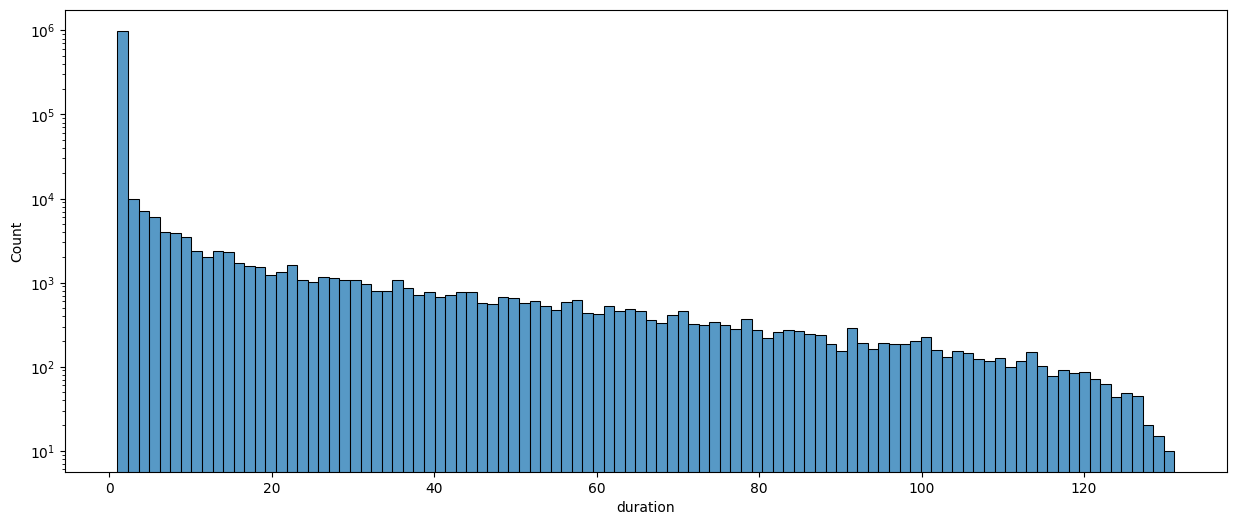

In [68]:
# распределение пользователей по общей продолжительности их взаимодействия с системой (в днях)
user_tf = events.groupby('visitorid').agg(min_ts=('timestamp','min'), max_ts=('timestamp','max')).reset_index()
user_tf['duration'] = (user_tf['max_ts'] - user_tf['min_ts'] -1)/(24*3600*1000) +1
fig = plt.figure()
fig.set_size_inches (15, 6, forward=True)
sns.histplot(user_tf, x='duration', bins=100, log=True)
plt.show()


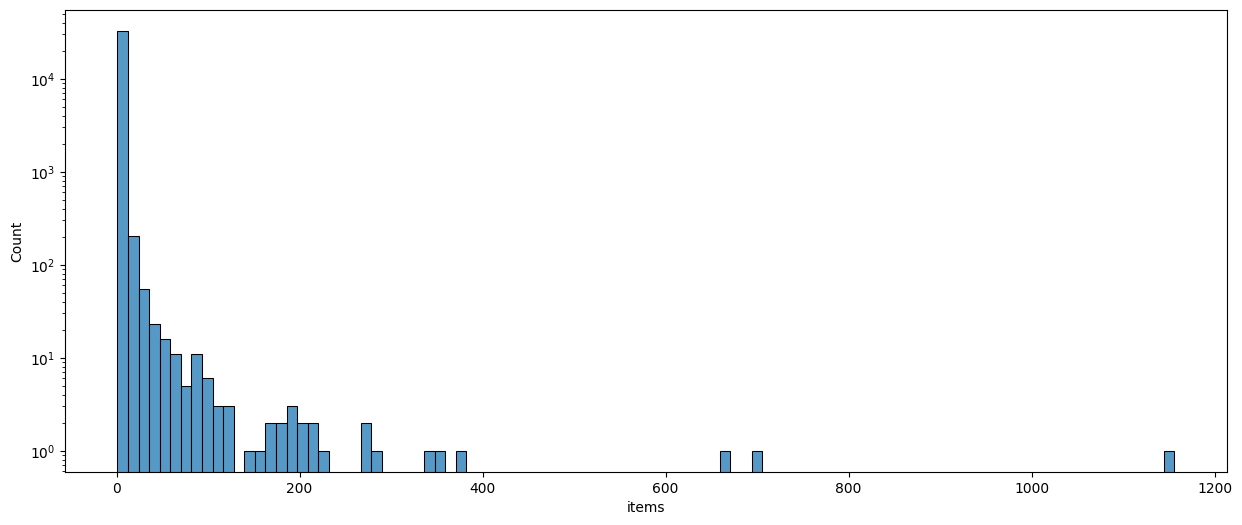

In [69]:
# распределение целевых взаимодействий по пользователям
item_per_user = events.query("event > 0").groupby('visitorid').agg(items=('itemid','count')).reset_index()

fig = plt.figure()
fig.set_size_inches (15, 6, forward=True)
sns.histplot(item_per_user, x='items', bins=100, log=True)
plt.show()

del item_per_user

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


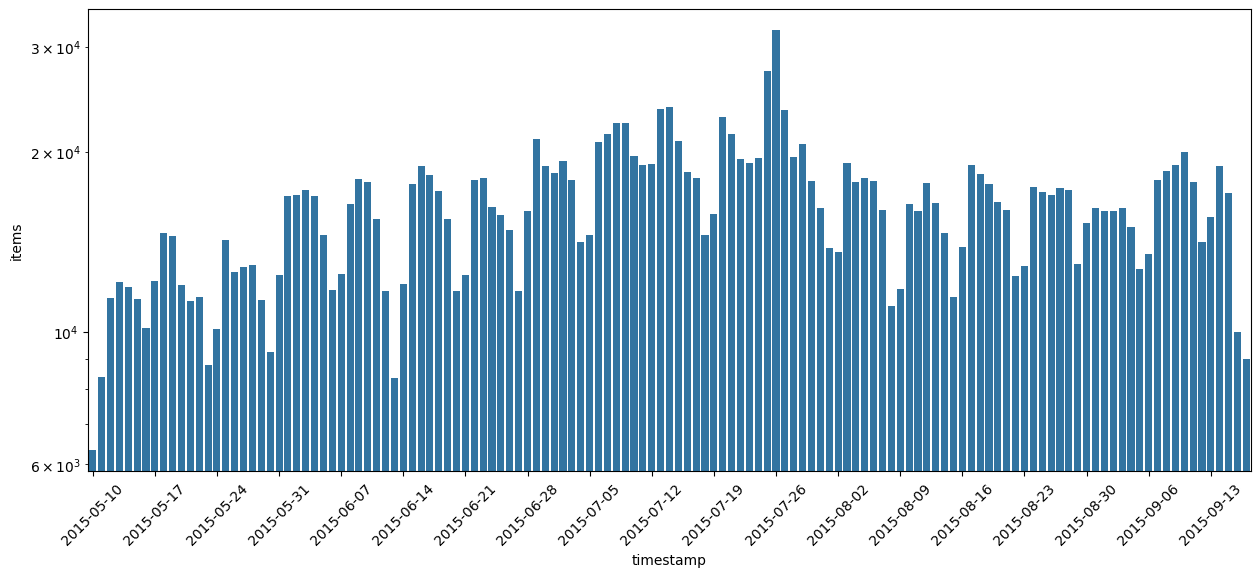

In [70]:
# визуализируем распределение events по дням
item_per_day = events.groupby(pd.to_datetime(events['timestamp'], unit='ms').dt.date).agg(
    items=('itemid','count')
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(item_per_day, x='timestamp', y='items', log=True, ax=ax)

plt.xticks (rotation=45)
ax.set_xticks(ax.get_xticks()[::7])
ax.tick_params(axis='x', which='minor', bottom=False)
plt.show()
#del item_per_day

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


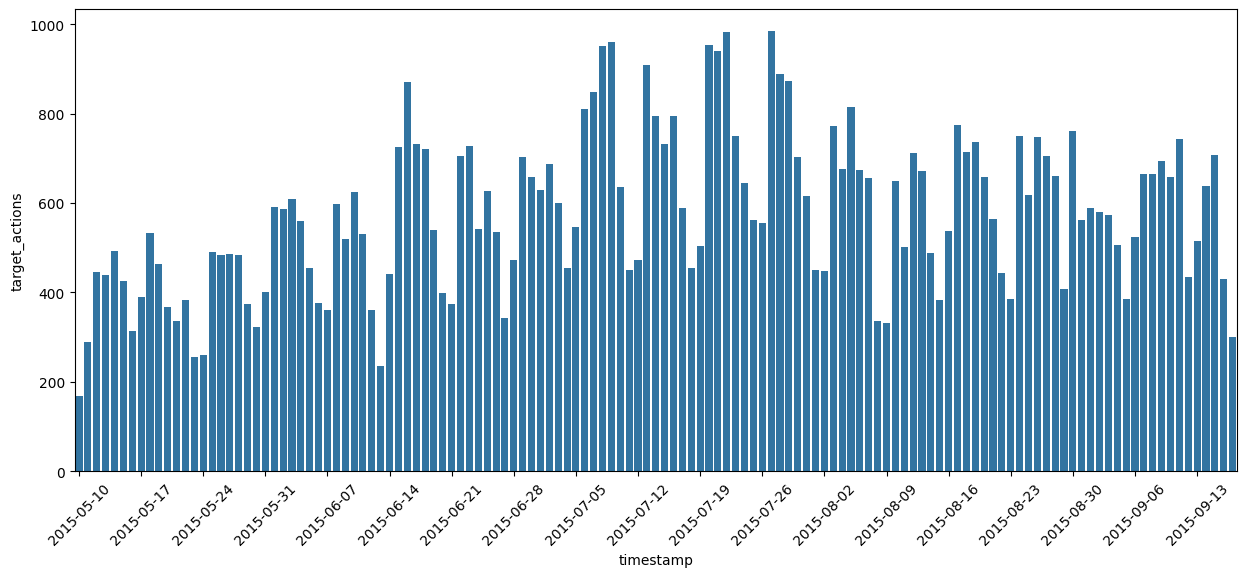

In [71]:
# визуализируем количество целевых действий пользователей (добавление в корзину + покупки) по дням
event_per_day = events.groupby(pd.to_datetime(events['timestamp'], unit='ms').dt.date)['event'] \
                      .value_counts().unstack(fill_value=0)
event_per_day['target_actions'] = event_per_day[1] + event_per_day[2]

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(event_per_day, x='timestamp', y='target_actions', ax=ax)

plt.xticks (rotation=45)
ax.set_xticks(ax.get_xticks()[::7])
ax.tick_params(axis='x', which='minor', bottom=False)
plt.show()

#del event_per_day

<Axes: xlabel='timestamp'>

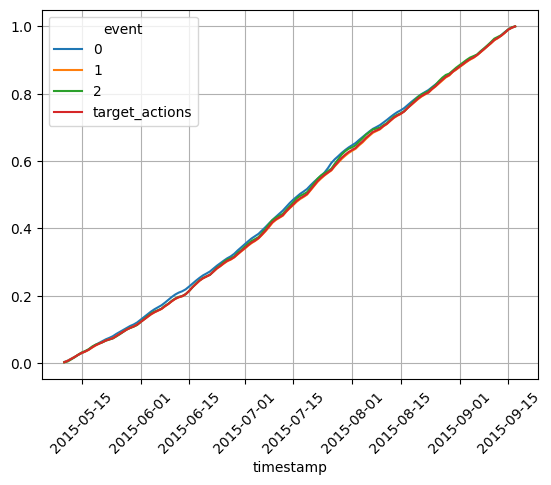

In [72]:
# кумулятивное количество целевых действий (для выбора split_date и inference_date)
events_percent = (event_per_day / event_per_day.sum()).cumsum()
events_percent.plot(kind='line', rot=45, grid=True)

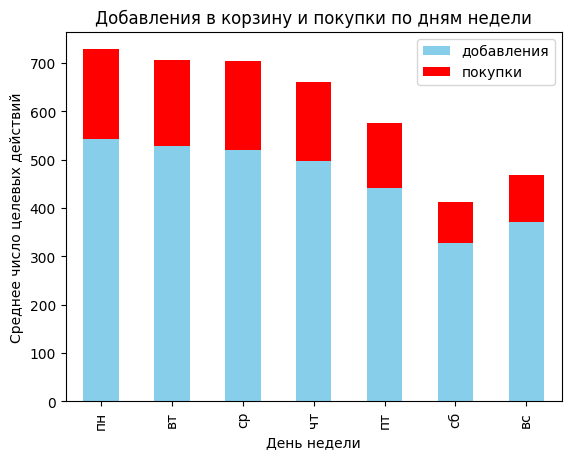

In [73]:
# визуализируем количество целевых действий пользователей (добавление в корзину + покупки) по дням недели
event_per_weekday = events.groupby(pd.to_datetime(events['timestamp'], unit='ms').dt.dayofweek)['event'] \
                          .value_counts().unstack(fill_value=0).drop(columns=[0]).astype(float)

# для каждого дня недели делим value_counts на соответствующее число недель (к-во вхождений данного дня в диапазон дат)
for dw in range(7):
    event_per_weekday.loc[(pd.to_datetime(items['timestamp'].min(), unit='ms').dayofweek +dw)%7, :] /= (
        pd.to_datetime(events['timestamp'].max(), unit='ms') - 
        pd.to_datetime(events['timestamp'].min()+ dw *1440*60*1000, unit='ms')
    ).days // 7
event_per_weekday.plot(kind='bar', stacked=True, color=['skyblue','red'])

plt.xticks(range(7), labels=['пн','вт','ср','чт','пт','сб','вс'])
plt.xlabel('День недели')
plt.ylabel('Среднее число целевых действий')
plt.title ('Добавления в корзину и покупки по дням недели')
plt.legend(['добавления','покупки'])
plt.show()

del event_per_weekday

##### Из приведенных визуализаций следует:
1. Подавляющее большинство клиентов являются "однодневками", совершающими некоторое количество взаимодействий с сервисом в течение одного-двух дней и больше не возвращающимися.
2. Подавляющее большинство **целевых** взаимодействий (добавление в корзину/покупка) совершаются пользователями
с ограниченным ассортиментом "любимых" товаров
3. Явно выраженной сезонности в количестве как общих, так и целевых взаимодействий пользователей с системой не наблюдается.
Вместе с тем, имеет место явное снижение количества целевых взаимодействий в отдельные дни недели (суббота, воскресенье и, отчасти, пятница)

### ВЫВОДЫ
1. Такая структура клиентской базы влечет за собой необходимость работы с очень большим количеством "холодных" пользователей, что повышает значимость онлайн-рекомендаций, основанных на подборе **_подобных_** товаров.
2. В качестве "технологического окна" для формирования новых рекомендаций на основе свежих данных целесообразно выбрать ночь с субботы на воскресенье.


## ФОРМИРОВАНИЕ РЕКОМЕНДАЦИЙ ##

In [74]:
# загружаем очищенные данные

with s3.open(f"{S3_DIR}/data/category_tree.parquet", mode='rb') as fd:
    ctree = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_properties.parquet", mode='rb') as fd:
    items = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_categories.parquet", mode='rb') as fd:
    items_ctgr = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/item_availability.parquet", mode='rb') as fd:
    items_avail = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/events.parquet", mode='rb') as fd:
    events = pd.read_parquet(fd)

with s3.open(f"{S3_DIR}/data/transactions.parquet", mode='rb') as fd:
    transact = pd.read_parquet(fd)


In [75]:
# смотрим данные для выбора train_test_split_date и inference_split_date

for date in pd.date_range(start=pd.to_datetime("2015-08-15"), end=pd.to_datetime("2015-09-10"), freq='D'):
    
    train_test_global_time_split_idx = events['timestamp'] < pd.Timestamp(date).value/1000000
    events_train = events[train_test_global_time_split_idx]
    events_test  = events[~train_test_global_time_split_idx]

    hot_users = events_test[events_test['visitorid'].isin(events_train['visitorid'].unique())]['visitorid'].unique()
    print(
        "Split date:", pd.to_datetime(pd.Timestamp(date).value/1000000, unit='ms').date(),
        "  Events percent:", round(events_train.shape[0] / events.shape[0] *100, 4),
        "  Hot users:", len(hot_users),
        "  Cold users:", events_test.query("visitorid not in @hot_users")['visitorid'].nunique()
    )


Split date: 2015-08-15   Events percent: 74.4812   Hot users: 20123   Cold users: 272980
Split date: 2015-08-16   Events percent: 75.0258   Hot users: 19964   Cold users: 266910
Split date: 2015-08-17   Events percent: 75.6865   Hot users: 19839   Cold users: 259474
Split date: 2015-08-18   Events percent: 76.5928   Hot users: 19542   Cold users: 249945
Split date: 2015-08-19   Events percent: 77.4662   Hot users: 19190   Cold users: 240669
Split date: 2015-08-20   Events percent: 78.3082   Hot users: 18777   Cold users: 231790
Split date: 2015-08-21   Events percent: 79.0941   Hot users: 18378   Cold users: 223702
Split date: 2015-08-22   Events percent: 79.8555   Hot users: 17939   Cold users: 215700
Split date: 2015-08-23   Events percent: 80.4457   Hot users: 17663   Cold users: 209260
Split date: 2015-08-24   Events percent: 81.059   Hot users: 17416   Cold users: 202206
Split date: 2015-08-25   Events percent: 81.8905   Hot users: 16968   Cold users: 193398
Split date: 2015-08-26

In [76]:
# разбиваем данные на тренировочную, валидационную и тестовую выборки

train_test_split_date = pd.to_datetime("2015-08-19")        # берем в train порядка 77% events (среда)
inference_split_date  = pd.to_datetime("2015-09-02")        # среда, разбивающая тестовую выборку почти пополам
if INFER_MODE: train_test_split_date = inference_split_date # для расчета inference расширяем train-набор


train_test_global_time_split_idx = pd.to_datetime(events['timestamp'], unit='ms') < train_test_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test  = events[~train_test_global_time_split_idx] #.copy()
del train_test_global_time_split_idx

# пользователи, для которых понадобятся персональные рекомендации
hot_users = events_test[events_test['visitorid'].isin(events_train['visitorid'].unique())]['visitorid'].unique()

# выделяем из тестовой выборки валидационную (events_target)
target_test_global_time_split_idx = pd.to_datetime(events_test['timestamp'], unit='ms') < inference_split_date
events_target = events_test[target_test_global_time_split_idx].copy()
events_test   = events_test[~target_test_global_time_split_idx].copy()
del target_test_global_time_split_idx
del events

if INFER_MODE and events_target.shape[0] > 0:
    raise Exception("В режиме INFER_MODE events_target должен быть ПУСТЫМ")
events_target.nunique(), events_target['event'].value_counts()

(timestamp        0
 visitorid        0
 event            0
 itemid           0
 transactionid    0
 categoryid       0
 available        0
 root             0
 dtype: int64,
 Series([], Name: count, dtype: int64))

In [77]:
events_test.nunique(), events_test['event'].value_counts()

(timestamp        250850
 visitorid        141289
 event                 3
 itemid            65128
 transactionid      1647
 categoryid         1005
 available             2
 root                 22
 dtype: int64,
 event
 0    242217
 1      6929
 2      2093
 Name: count, dtype: int64)

### Расчет персональных коллаборативных рекомендаций ###

In [78]:
import scipy
from implicit.als            import AlternatingLeastSquares
from implicit.evaluation     import mean_average_precision_at_k, precision_at_k
from sklearn.model_selection import ParameterGrid
from catboost                import CatBoostClassifier, Pool
from threadpoolctl           import threadpool_limits
threadpool_limits(1, "blas")


In [79]:
def als_validate(csr_train, csr_val, k=10, **kwargs):
    ''' Обучает и валидирует ALS с заданными гиперпараметрами '''
    model = AlternatingLeastSquares(random_state=RANDOM_STATE, **kwargs)
    model.fit(csr_train)
    map_k = mean_average_precision_at_k(model, csr_train, csr_val, k, show_progress=False)
    print(f"{kwargs} ==> MAP@{k}: {map_k:6.5f}")
    #map_k = precision_at_k(model, csr_train, csr_val, k, show_progress=False)
    #print(f"{kwargs} ==> Precision@{k}: {map_k:6.5f}")
    return  model, map_k


def als_train(csr_train, csr_val, **hyper_params):
    ''' Обучает ALS с возможным подбором гиперпараметров '''

    if hyper_params:
        model = AlternatingLeastSquares(random_state=RANDOM_STATE, **hyper_params)
        model.fit(csr_train)
        return  model, hyper_params
    
    grid = {
        'alpha':     [100.0], 'regularization':[0.005,1.0], 
        'iterations':[15,10],        'factors':[150,100]
    }
    best_metric = 0
    best_params = {}
    best_model  = None

    for params in list(ParameterGrid(grid)):
        model, metric = als_validate(csr_train, csr_val, **params)
        if metric > best_metric:
            best_metric = metric
            best_params = params
            best_model  = model
    return  best_model, best_params



In [80]:
def calc_item_rating(df):
    ''' Формирует вектор рейтинга взаимодействий: наличие просмотров + добавления в корзину + покупки*2 '''
    return ((df[0] > 0) + df[1] + df[2]*2).astype(np.int16)

def user_item_matrix(events_set, users):
    ''' Формирует и возвращает матрицу взаимодействий в dense и sparse формате '''
    user_item = events_set.query("visitorid in @users").groupby(['visitorid','itemid'])['event'] \
                          .value_counts().unstack(fill_value=0).reset_index()
    
    # формируем рейтинг взаимодействий
    user_item['rating'] = calc_item_rating(user_item)  #((user_item[0] > 0) + user_item[1] + user_item[2]*2).astype(np.int16)
    return user_item, scipy.sparse.csr_matrix(
          (user_item['rating'], (user_item['visitorid'], user_item['itemid']))
    )


In [81]:
# матрица взаимодействий на тренировочной выборке
user_item_train, user_item_matrix_train = user_item_matrix(events_train, events_train['visitorid'].unique())
#user_item_train, user_item_matrix_train = user_item_matrix(events_train, hot_users)
user_item_train.sort_values (by='rating', ascending=False).head()


event,visitorid,itemid,0,1,2,rating
6807,6958,431417,5,29,1,32
6780,6958,184011,1,26,1,29
6796,6958,339822,3,24,1,27
6799,6958,374855,8,25,0,26
154199,152963,119736,10,0,12,25


In [82]:
# матрица взаимодействий на валидационной выборке
user_item_val, user_item_matrix_val = user_item_matrix(events_test  if INFER_MODE  else events_target, hot_users)
user_item_val.sort_values (by='rating', ascending=False).head()


event,visitorid,itemid,0,1,2,rating
13232,661052,204235,0,12,0,12
10200,518659,387697,12,2,3,9
1147,75630,79056,12,2,3,9
23963,1172087,312728,5,0,4,9
24700,1213423,185863,4,3,2,8


In [83]:
%%exec_if CALC_ALS

# Обучаем и сохраняем ALS-модель (гиперпараметры по умолчанию подобраны в режиме ALS_GRID==True)
als_params = {} if ALS_GRID  else {'alpha': 100.0, 'factors': 150, 'iterations': 10, 'regularization': 0.005}
als_model, als_params = als_train (user_item_matrix_train, user_item_matrix_val, **als_params)

if ALS_GRID:
    with open(f"{DATA_DIR}/als_params.txt", mode='w') as fd:
        print(als_params, file=fd)
    with s3.open(f"{S3_DIR}/data/als_params.pkl", mode='wb') as fd:
        joblib.dump (als_params, fd)

with s3.open(f"{S3_DIR}/data/als_model{'_infer' if INFER_MODE else ''}.pkl", mode='wb') as fd:
    joblib.dump (als_model, fd)

als_params

  0%|          | 0/10 [00:00<?, ?it/s]

{'alpha': 100.0, 'factors': 150, 'iterations': 10, 'regularization': 0.005}

In [84]:
%%exec_if not CALC_ALS

# загружаем ранее сохраненную модель
with s3.open(f"{S3_DIR}/data/als_model{'_infer' if INFER_MODE else ''}.pkl", mode='rb') as fd:
    als_model = joblib.load(fd)

In [85]:
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int16'
	with 1426126 stored elements and shape (1407580, 466865)>

In [86]:
%%exec_if CALC_RECS

# получаем рекомендации для "горячих" пользователей
RECS_PER_USER = 15
als_recommendations = als_model.recommend(
    hot_users, 
    user_item_matrix_train[hot_users], 
    filter_already_liked_items=True, N=RECS_PER_USER
)
print(als_recommendations[0].shape)

personal_als  = pd.DataFrame({
    'itemid'   : als_recommendations[0].ravel(),
    'als_score': als_recommendations[1].ravel()
}, index=pd.MultiIndex.from_product([hot_users, range(RECS_PER_USER)], names=['visitorid', 'als_rank'])).reset_index()

del als_recommendations, user_item_matrix_train

with s3.open(f"{S3_DIR}/data/personal_als{'_infer' if INFER_MODE else ''}.parquet", mode='wb') as fd:
    personal_als.to_parquet(fd)



(13012, 15)


In [87]:
%%exec_if not CALC_RECS
with s3.open(f"{S3_DIR}/data/personal_als{'_infer' if INFER_MODE else ''}.parquet", mode='rb') as fd:
    personal_als = pd.read_parquet(fd)

In [88]:
personal_als.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195180 entries, 0 to 195179
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   visitorid  195180 non-null  int64  
 1   als_rank   195180 non-null  int64  
 2   itemid     195180 non-null  int32  
 3   als_score  195180 non-null  float32
dtypes: float32(1), int32(1), int64(2)
memory usage: 4.5 MB


In [89]:
# удачные рекомендации...

personal_als.merge(
    user_item_val, how='inner', on=['visitorid','itemid']
).groupby('visitorid').agg(
    items=('itemid','count'), clicks=(0,'sum'), addtochart=(1,'sum'), purchase=(2,'sum'), rating=('rating','sum')
).sort_values(by='rating', ascending=False)

,items,clicks,addtochart,purchase,rating
visitorid,,,,,
283553,8,39,2,1,12
1114419,5,35,0,0,5
221662,2,4,1,1,5
741985,5,18,0,0,5
981375,3,2,4,0,5
...,...,...,...,...,...
508015,1,1,0,0,1
508673,1,1,0,0,1
512866,1,1,0,0,1


### Расчет ALS-схожести объектов ###

In [90]:
%%exec_if CALC_RECS

# получаем подобные для всех товаров, попавших в рекомендации
SIMS_PER_ITEM = 20
sim_items = als_model.similar_items(personal_als['itemid'].unique(), N=SIMS_PER_ITEM)

als_similar = pd.DataFrame({
    'sim_itemid': sim_items[0].ravel(),
    'sim_score' : sim_items[1].ravel()
}, index=pd.MultiIndex.from_product(
    [personal_als['itemid'].unique(), range(SIMS_PER_ITEM)], names=['itemid', 'sim_rank']
)).reset_index()

with s3.open(f"{S3_DIR}/data/als_similar{'_infer' if INFER_MODE else ''}.parquet", mode='wb') as fd:
    als_similar.to_parquet(fd)
    
del sim_items

In [91]:
%%exec_if not CALC_RECS
with s3.open(f"{S3_DIR}/data/als_similar{'_infer' if INFER_MODE else ''}.parquet", mode='rb') as fd:
    als_similar = pd.read_parquet(fd)

In [92]:
print(als_similar.head(),'\n')
als_similar.info()

   itemid  sim_rank  sim_itemid  sim_score
0  306763         0      306763   1.000000
1  306763         1      392837   0.992629
2  306763         2       30444   0.992460
3  306763         3      396452   0.991768
4  306763         4      381990   0.880415 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243940 entries, 0 to 243939
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   itemid      243940 non-null  int32  
 1   sim_rank    243940 non-null  int64  
 2   sim_itemid  243940 non-null  int32  
 3   sim_score   243940 non-null  float32
dtypes: float32(1), int32(2), int64(1)
memory usage: 4.7 MB


### Наиболее популярные товары

In [93]:
%%exec_if CALC_RECS
from sklearn.preprocessing import MinMaxScaler

# наиболее покупаемые товары в тренировочной выборке
top_popular = events_train.groupby(['itemid'])['event'].value_counts().unstack(fill_value=0) \
                          .sort_values(by=2,ascending=False).head(100)

# считаем и масштабируем рейтинг популярности
top_popular['rating']    = calc_item_rating(top_popular)
top_popular['pop_score'] = MinMaxScaler().fit_transform(top_popular['rating'].to_frame())

# сортируем по скорингу
top_popular = top_popular[['rating','pop_score']].sort_values(by='rating',ascending=False).reset_index()

with s3.open(f"{S3_DIR}/data/top_popular{'_infer' if INFER_MODE else ''}.parquet", mode='wb') as fd:
    top_popular.to_parquet(fd)

In [94]:
%%exec_if not CALC_RECS
with s3.open(f"{S3_DIR}/data/top_popular{'_infer' if INFER_MODE else ''}.parquet", mode='rb') as fd:
    top_popular = pd.read_parquet(fd)

In [95]:
print(top_popular.head(),'\n')
top_popular.info()

event  itemid  rating  pop_score
0      461686     461   1.000000
1      312728     220   0.443418
2       48030     178   0.346420
3      445351     161   0.307159
4      320130     146   0.272517 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   itemid     100 non-null    int64  
 1   rating     100 non-null    int16  
 2   pop_score  100 non-null    float64
dtypes: float64(1), int16(1), int64(1)
memory usage: 1.9 KB


In [96]:
# объединяем информацию из personal_als, als_similar и top_popular в привязке к visitorid

candidades = personal_als[['visitorid','itemid']].merge(
    als_similar, how='left', on='itemid'
).groupby(['visitorid','sim_itemid']).agg(
    sim_score=('sim_score','max')
).reset_index().rename(
    columns={'sim_itemid': 'itemid'} 
).merge(
    personal_als[['visitorid','itemid','als_score']], how='outer', on=['visitorid','itemid']
).merge(
    top_popular[['itemid','pop_score']], how='left', on='itemid'
)
candidades.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437785 entries, 0 to 2437784
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   visitorid  2437785 non-null  int64  
 1   itemid     2437785 non-null  int32  
 2   sim_score  2437785 non-null  float32
 3   als_score  195180 non-null   float32
 4   pop_score  16491 non-null    float64
dtypes: float32(2), float64(1), int32(1), int64(1)
memory usage: 65.1 MB


### Формируем дополнительные признаки

In [97]:
%%exec_if not INFER_MODE

# формируем таргет для модели ранжирования (добавления в корзину и покупки)
events_target['target'] = (events_target['event'] > 0).astype(np.int8)

# расширяем состав candidades за счет положительных сэмплов из events_target
candidades = candidades.merge(
    events_target.groupby(['visitorid','itemid']).agg(target=('target','max')).reset_index().query(
        "visitorid in @hot_users and target > 0"
    ), 
    how='outer', on=['visitorid','itemid']
)
candidades["target"] = candidades["target"].fillna(0).astype(np.int8)

candidades.info(show_counts=True)

In [98]:
candidades.nunique()

visitorid     13012
itemid        69427
sim_score    164675
als_score    189794
pop_score        56
dtype: int64

In [99]:
# простейшие признаки пользователя - "стаж" и активность в train-периоде

user_features = events_train.query("visitorid in @hot_users").groupby("visitorid").agg(
    stage  =('timestamp', lambda x: (train_test_split_date - pd.to_datetime(x.min(),unit='ms')).days +1),
    nclicks=('timestamp', 'count'),
    nbuys  =('transactionid', 'count')
).reset_index()
user_features["click_per_day"] = user_features["nclicks"] / user_features["stage"]

# конверсия
user_features["buy_per_click"] = user_features["nbuys"]   / user_features["nclicks"]

user_features.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13012 entries, 0 to 13011
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   visitorid      13012 non-null  int64  
 1   stage          13012 non-null  int64  
 2   nclicks        13012 non-null  int64  
 3   nbuys          13012 non-null  int64  
 4   click_per_day  13012 non-null  float64
 5   buy_per_click  13012 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 610.1 KB


In [100]:
# Получаем свойства товаров, актуальные на конец train-периода
item_props = get_item_properties(events_train['timestamp'].max())
item_props.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11050061 entries, 0 to 11050060
Data columns (total 3 columns):
 #   Column      Non-Null Count     Dtype
---  ------      --------------     -----
 0   itemid      11050061 non-null  int64
 1   property    11050061 non-null  int64
 2   value_code  11050061 non-null  int64
dtypes: int64(3)
memory usage: 252.9 MB


In [101]:
# считаем скоринг предпочтений пользователей по категориальным свойствам товаров
user_item_prop = candidades[['visitorid','itemid']].merge(
    item_props.query("itemid in @candidades['itemid'].unique() and property in @categorical_props"), 
    how='left', on='itemid'
)

#user_prop_score = user_item_prop.groupby(['visitorid','property','value_code']).agg(
user_prop_score = user_item_prop.groupby(['visitorid','property']).agg(
    prop_score=('itemid','nunique')
).reset_index()

user_item_prop_score = user_item_prop.merge(
    #user_prop_score, how='left', on=['visitorid','property','value_code']
    user_prop_score, how='left', on=['visitorid','property']
).groupby(['visitorid','itemid']).agg(
    prop_score=('prop_score','mean')
).fillna(0).reset_index()

#del user_item_prop, user_prop_score, item_props, prop_vals
user_item_prop_score.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437785 entries, 0 to 2437784
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   visitorid   2437785 non-null  int64  
 1   itemid      2437785 non-null  int32  
 2   prop_score  2437785 non-null  float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 46.5 MB


In [102]:
#%%exec_if False  # НЕ СЧИТАЕМ в связи с малозначимостью данных признаков, исходя из cb_model.get_feature_importance

# ... а также, предпочтения пользователей по категориям товаров

user_item_cat = events_train.query(
    "event>0 and visitorid in @hot_users"             # берем только целевые события
)[['visitorid','itemid','categoryid','root','event']]

user_cat_score = user_item_cat.groupby(['visitorid','categoryid']).agg(
    cat_score=('event','sum')
).reset_index()

user_root_score = user_item_cat.groupby(['visitorid','root']).agg(
    root_score=('event','sum')
).reset_index()

user_item_cat_score = user_item_cat.merge(
    user_cat_score, how='left', on=['visitorid','categoryid']
)[['visitorid','itemid','cat_score']].merge(
    candidades[['visitorid','itemid']], how='right', on=['visitorid','itemid']
).fillna(0)

user_item_root_score = user_item_cat.merge(
    user_root_score, how='left', on=['visitorid','root']
)[['visitorid','itemid','root_score']].merge(
    candidades[['visitorid','itemid']], how='right', on=['visitorid','itemid']
).fillna(0)

del user_item_cat, user_cat_score, user_root_score
user_item_cat_score.info(show_counts=True)
user_item_root_score.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438237 entries, 0 to 2438236
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   visitorid  2438237 non-null  int64  
 1   itemid     2438237 non-null  int64  
 2   cat_score  2438237 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 55.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438237 entries, 0 to 2438236
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   visitorid   2438237 non-null  int64  
 1   itemid      2438237 non-null  int64  
 2   root_score  2438237 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 55.8 MB


In [103]:
# считаем hit_score, который пригодится для расчета метрики novelty

user_item_hit_score = events_train.query("visitorid in @hot_users").groupby(
    ['visitorid','itemid']
).agg(
    hit_score=('event','nunique')
).reset_index().merge(
    candidades[['visitorid','itemid']], how='right', on=['visitorid','itemid']
).fillna(0)
user_item_hit_score.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437785 entries, 0 to 2437784
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   visitorid  2437785 non-null  int64  
 1   itemid     2437785 non-null  int64  
 2   hit_score  2437785 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 55.8 MB


In [104]:
# нормализуем user_item_prop_score по каждому пользователю

def normalize_col_by_col(df: pd.DataFrame, col: str, by_col: str):
    from sklearn.preprocessing import normalize
    tmp      = df.sort_values(by=by_col)
    tmp[col] = tmp.groupby(by_col)[col].apply(
        lambda x: normalize(x.values.reshape(-1,1), norm='l1', axis=0, copy=True, return_norm=True)[0].ravel()
    ).explode(col).values.astype('float32')
    df[col]  = tmp[col]

normalize_col_by_col(user_item_prop_score, 'prop_score', 'visitorid')
normalize_col_by_col(user_item_cat_score,  'cat_score',  'visitorid')
normalize_col_by_col(user_item_root_score, 'root_score', 'visitorid')

# убеждаемся в корректности нормализации на произвольном пользователе
test_scores = user_item_prop_score.query("visitorid== @user_item_prop_score['visitorid'][0]")
user_item_prop_score.head(),  test_scores['prop_score'].sum(), test_scores.shape[0]

(   visitorid  itemid  prop_score
 0        155    2142    0.002320
 1        155    6134    0.005973
 2        155    8806    0.002320
 3        155   14114    0.000000
 4        155   17437    0.002378,
 0.99999994,
 151)

In [105]:
# вносим сформированные дополнительные признаки в candidades_for_train

candidades = candidades.merge(
    user_item_prop_score, how='left', on=['visitorid','itemid']
).merge(
    user_item_hit_score,  how='left', on=['visitorid','itemid']
).merge(
    user_item_cat_score,  how='left', on=['visitorid','itemid']
).merge(
    user_item_root_score, how='left', on=['visitorid','itemid']
).merge(
    user_features[['visitorid','stage','click_per_day','buy_per_click']], how='left', on=['visitorid']
)

# объединяем als-скоринги
candidades['sim_score'] = candidades['als_score'].fillna(1) * candidades['sim_score'].fillna(0)
candidades.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2439561 entries, 0 to 2439560
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   visitorid      2439561 non-null  int64  
 1   itemid         2439561 non-null  int32  
 2   sim_score      2439561 non-null  float32
 3   als_score      195180 non-null   float32
 4   pop_score      16686 non-null    float64
 5   prop_score     2439561 non-null  float32
 6   hit_score      2439561 non-null  float64
 7   cat_score      2439561 non-null  float32
 8   root_score     2439561 non-null  float32
 9   stage          2439561 non-null  int64  
 10  click_per_day  2439561 non-null  float64
 11  buy_per_click  2439561 non-null  float64
dtypes: float32(5), float64(4), int32(1), int64(2)
memory usage: 167.5 MB


In [106]:
# задаём имена колонок признаков
feature_cols = ['sim_score','pop_score','prop_score','hit_score',
                'cat_score','root_score',#'als_score',
                'stage','click_per_day','buy_per_click']


##  РАНЖИРОВАНИЕ РЕКОМЕНДАЦИЙ

In [107]:
import mlflow

def reg_model(model, X, y_pred, metrics, params, artifacts=None, runid=None, desc="Experimental logging"):
    ''' Логирование новой версии модели и/или артефактов в MLFlow '''

    mlflow.set_tracking_uri(MLFLOW_SERVER_URL)
    logging.info(f"MLFlow tracking URL set to: {mlflow.get_tracking_uri()}")
    experiment_id = mlflow.set_experiment(EXPERIMENT_NAME).experiment_id
    logging.info(f"MLFlow experiment name/id: {EXPERIMENT_NAME}/{experiment_id}")

    with mlflow.start_run(run_id=runid, run_name=f"{MODEL_NAME}_run", experiment_id=experiment_id, description=desc) as run:
        run_id = run.info.run_id

        if artifacts is not None:
            for key,val in artifacts.items():
                mlflow.log_dict(val, f"{key}.json")
                logging.info(f"MLFlow artifact {key}.json logged (run_id:{run_id})")

        if metrics is not None:
            mlflow.log_metrics(metrics)

        if  model is not None:
            input_example = X[:10]
            signature     = mlflow.models.infer_signature(X, y_pred)
            model_info    = mlflow.catboost.log_model(
                cb_model             = model,
                registered_model_name= MODEL_NAME,
                input_example        = input_example,
                signature            = signature,
                await_registration_for=0,
                artifact_path        = f'model'
            )
            mlflow.log_params(params)
            mlflow.set_tag('estimator', 'CatBoostClassifier')
            logging.info(f"Model <{MODEL_NAME}> registered successfully (run_id:{run_id})")

    logging.info(f"MLFlow run {run_id} closed")
    return run_id



### Формируем исходные данные для модели

In [108]:
%%exec_if not INFER_MODE
# наблюдаем огромный дисбаланс классов, несмотря на произведенный oversampling положительного таргета
candidades['target'].value_counts()

In [109]:
%%exec_if not INFER_MODE
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidades_for_train = candidades.groupby("visitorid").filter(lambda x: x["target"].sum() > 0)

# убираем неинформативные дубликаты (гарантированно оставляя положительный таргет)
candidades_for_train = candidades_for_train.sort_values(by='target',ascending=False).drop_duplicates(
    subset=['visitorid','itemid']+feature_cols, keep='first'
)
candidades_for_train.info(show_counts=True)

In [110]:
%%exec_if not INFER_MODE
# смотрим, с чем остались...
candidades_for_train['target'].value_counts()

In [111]:
%%exec_if not INFER_MODE

def cb_train(train_pool, **hyper_params):
    ''' Обучает Catboost с возможным подбором гиперпараметров '''

    model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, 
        auto_class_weights='Balanced', loss_function='Logloss', eval_metric='Recall', **hyper_params
    )
    if hyper_params:
        model.fit(train_pool)
        return  model, hyper_params
    
    grid = {
        'l2_leaf_reg':  [1, 3, 5],
        'learning_rate':[0.01, 0.09, 0.12, 0.14, 0.16, 0.18],
        'iterations'   :[10,100,500,1000],
        'depth'        :[6, 8, 10, 12],
    }
    test_grid = {
        'l2_leaf_reg':  [1, 2],
        'learning_rate':[0.14, 0.12927],
        'iterations'   :[10, 998],
        'depth'        :[6,  10],
    }
    
    result = model.grid_search(test_grid, X=train_pool, stratified=True, partition_random_seed=RANDOM_STATE, 
        refit=True, plot=True, plot_file=f"{DATA_DIR}/../logs/cb_search.html", verbose=False 
    )
    return  model, result['params']

# ==============  Подбор параметров с использованием bayes-оптимизации (~ 10 минут)  ============== #
def cb_train_bayes(X, y):
    ''' Обучает Catboost с подбором гиперпараметров '''

    model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, 
        auto_class_weights='Balanced', loss_function='Logloss', eval_metric='Recall'
    )

    from skopt import BayesSearchCV
    searchcv = BayesSearchCV(
        model,
        search_spaces={
            'learning_rate' : (0.03, 0.3, 'uniform'),
            'l2_leaf_reg'   : (1, 7),
            'depth'         : (4, 10),
            'iterations'    : (10,1000)
        },
        #fit_params={'show_progress': True},
        #scoring=als_scorer,
        n_iter=30,
        cv=3,
        random_state=RANDOM_STATE,
    )
    searchcv.fit(X, y)
    return  searchcv.best_estimator_, dict(searchcv.best_params_)
# =================================================================================================== #


# Обучаем ранжирующую модель
train_data = Pool(data=candidades_for_train[feature_cols], label=candidades_for_train['target'])

cb_params = {} if CB_GRID  else {'depth': 9, 'learning_rate': 0.0364, 'l2_leaf_reg': 1, 'iterations': 640}
#cb_model, cb_params = cb_train (train_data, **cb_params)
cb_model, cb_params = cb_train_bayes (candidades_for_train[feature_cols], candidades_for_train['target'])

if CB_GRID:
    with open(f"{DATA_DIR}/cb_params.txt", mode='w') as fd:
        print(cb_params, file=fd)
    with s3.open(f"{S3_DIR}/data/cb_params.pkl", mode='wb') as fd:
        joblib.dump (cb_params, fd)

with s3.open(f"{S3_DIR}/data/cb_model.pkl", mode='wb') as fd:
    joblib.dump (cb_model, fd)

cb_params


In [112]:
%%exec_if INFER_MODE
# загружаем ранее сохраненную модель
with s3.open(f"{S3_DIR}/data/cb_model.pkl", mode='rb') as fd:
    cb_model = joblib.load(fd)

In [113]:
# смотрим оценку важности признаков
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), index=feature_cols, columns=["fi"])
feature_importance = feature_importance.sort_values(by="fi", ascending=False)
print(feature_importance )

                      fi
sim_score      82.976775
hit_score       8.946334
click_per_day   4.029027
prop_score      2.233580
stage           0.575159
pop_score       0.507194
buy_per_click   0.485506
root_score      0.175283
cat_score       0.071142


In [114]:
#%%exec_if CALC_RECS

inference_data = Pool(data=candidades[feature_cols])
predictions = cb_model.predict_proba(inference_data)

candidades["cb_score"] = predictions[:,1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidades.sort_values(['visitorid', 'cb_score', 'sim_score', 'hit_score', 'prop_score', 'pop_score'], 
                       ascending=[True, False, False, False, False, False], inplace=True
)
candidades["rank"] = candidades.groupby("visitorid")["cb_score"].cumcount() +1

max_recommendations_per_user = 100
final_recommendations = candidades.query(
    "rank <= @max_recommendations_per_user"
)[['visitorid','itemid','rank','cb_score','als_score']+feature_cols]

with s3.open(f"{S3_DIR}/data/final_recommendations.parquet", mode='wb') as fd:
    final_recommendations.to_parquet(fd)


In [115]:
%%exec_if not CALC_RECS
with s3.open(f"{S3_DIR}/data/final_recommendations.parquet", mode='rb') as fd:
    final_recommendations = pd.read_parquet(fd)

In [116]:
final_recommendations.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1276406 entries, 40 to 2439542
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   visitorid      1276406 non-null  int64  
 1   itemid         1276406 non-null  int32  
 2   rank           1276406 non-null  int64  
 3   cb_score       1276406 non-null  float64
 4   als_score      179959 non-null   float32
 5   sim_score      1276406 non-null  float32
 6   pop_score      16381 non-null    float64
 7   prop_score     1276406 non-null  float32
 8   hit_score      1276406 non-null  float64
 9   cat_score      1276406 non-null  float32
 10  root_score     1276406 non-null  float32
 11  stage          1276406 non-null  int64  
 12  click_per_day  1276406 non-null  float64
 13  buy_per_click  1276406 non-null  float64
dtypes: float32(5), float64(5), int32(1), int64(3)
memory usage: 116.9 MB


## ОЦЕНКА КАЧЕСТВА

In [117]:
final_recommendations.head(10)

,visitorid,itemid,rank,cb_score,als_score,sim_score,pop_score,prop_score,hit_score,cat_score,root_score,stage,click_per_day,buy_per_click
40,155,123027,1,0.853161,NaN,0.855652,NaN,0.010265,1.0,0.0,0.0,20,0.35,0.0
42,155,134620,2,0.841799,NaN,0.816318,NaN,0.010265,1.0,0.0,0.0,20,0.35,0.0
51,155,151670,3,0.820548,NaN,0.647818,NaN,0.010265,1.0,0.0,0.0,20,0.35,0.0
17,155,50928,4,0.801395,NaN,0.729541,NaN,0.002378,1.0,0.0,0.0,20,0.35,0.0
130,155,373637,5,0.801395,NaN,0.707092,NaN,0.002378,1.0,0.0,0.0,20,0.35,0.0
95,155,273868,6,0.098815,NaN,0.996458,NaN,0.000000,0.0,0.0,0.0,20,0.35,0.0
147,155,462891,7,0.098815,NaN,0.983190,NaN,0.000116,0.0,0.0,0.0,20,0.35,0.0
21,155,60907,8,0.098815,NaN,0.979847,NaN,0.000116,0.0,0.0,0.0,20,0.35,0.0
16,155,50672,9,0.098815,NaN,0.945924,NaN,0.000000,0.0,0.0,0.0,20,0.35,0.0
120,155,344163,10,0.098815,NaN,0.931616,NaN,0.000116,0.0,0.0,0.0,20,0.35,0.0


In [118]:
def calc_bin_metrics(recs: pd.DataFrame, col_score: str, events: pd.DataFrame, N=10, verbose=False):
    ''' Расчет recall и precision для первых N рекомендаций

        recs   - должен содержать колонки ['visitorid','itemid', col_score] 
        events - должен содержать колонки ['visitorid','itemid','timestamp'] 
    '''
    common_users = set(recs['visitorid'].unique()) & set(events['visitorid'].unique())
    if verbose: print(f"Common users: {len(common_users)}")
    
    # формируем колонку 'hit' для пометки товаров, просмотренных пользователями в период events
    recs_for_metrics = recs.query("visitorid in @common_users").groupby('visitorid').head(N).merge(
        events.query("visitorid in @common_users").groupby(['visitorid','itemid']).agg(hit=('timestamp','count')),
        how='outer', left_on=['visitorid','itemid'], right_index=True
    )
    if verbose: print(recs_for_metrics.info(show_counts=True))

    # размечаем пары (user_id, item_id) для вычисления метрик precision и recall
    recs_for_metrics['fn'] = (recs_for_metrics[col_score].isna())
    recs_for_metrics['fp'] = (recs_for_metrics['hit'].isna())
    recs_for_metrics['tp'] = (recs_for_metrics['hit'].notna())  &  (recs_for_metrics[col_score].notna())
    if verbose: print(recs_for_metrics['fn'].sum(), recs_for_metrics['fp'].sum(), recs_for_metrics['tp'].sum())

    # считаем метрики в разрезе пользователей
    users_for_metrics = recs_for_metrics.groupby('visitorid').agg(
        fn=('fn','sum'), fp=('fp','sum'), tp=('tp','sum')
    )
    users_for_metrics['recall'] = users_for_metrics['tp'] / (users_for_metrics['tp'] + users_for_metrics['fn'])
    users_for_metrics['precision'] = users_for_metrics['tp'] / (users_for_metrics['tp'] + users_for_metrics['fp'])
    if verbose: print('\n', users_for_metrics.sort_values(by='tp', ascending=False).head(10))

    print (f"Значения метрик: "
           f"recall@{N}={users_for_metrics['recall'].mean(): >.3f}, "
           f"precision@{N}={users_for_metrics['precision'].mean(): >.3f}"
    )
    # возвращаем усредненные значения метрик по всем пользователям
    return  (users_for_metrics['recall'].mean(), users_for_metrics['precision'].mean())



In [119]:
# общие метрики
recall_at_10, _ = calc_bin_metrics(final_recommendations, 'cb_score', events_test, N=10)
recall_at_5,  _ = calc_bin_metrics(final_recommendations, 'cb_score', events_test, N=5)


Значения метрик: recall@10=0.131, precision@10=0.020
Значения метрик: recall@5=0.123, precision@5=0.035


In [120]:
# метрики для personal_als
als_recall_at_10, _ = calc_bin_metrics(final_recommendations, 'als_score', events_test, N=10)
als_recall_at_5,  _ = calc_bin_metrics(final_recommendations, 'als_score', events_test, N=5)


Значения метрик: recall@10=0.007, precision@10=0.002
Значения метрик: recall@5=0.004, precision@5=0.002


In [121]:
# метрики для top_popular
top = pd.DataFrame({   # эмулируем выдачу top_popular.head(10) рекомендаций для каждого пользователя
    'dummy_score': [i  for i in range(final_recommendations['visitorid'].nunique() *10, 0, -1)]
}, index=pd.MultiIndex.from_product(
    [final_recommendations['visitorid'].unique(), top_popular.head(10)['itemid']], names=['visitorid', 'itemid'])
).reset_index()

top_recall_at_10, _ = calc_bin_metrics(top, 'dummy_score', events_test, N=10)
top_recall_at_5,  _ = calc_bin_metrics(top, 'dummy_score', events_test, N=5)


Значения метрик: recall@10=0.005, precision@10=0.001
Значения метрик: recall@5=0.004, precision@5=0.002


In [122]:
def calc_novelty(recs: pd.DataFrame, col_score: str, past_events: pd.DataFrame, N=10, verbose=False):
    '''Расчет novelty для первых N рекомендаций

        recs   - должен содержать колонки ['visitorid','itemid', col_score] 
        events - должен содержать колонки ['visitorid','itemid','timestamp'] 
    '''

    # формируем колонку 'hit' для пометки товаров, просмотренных пользователями в период events
    recs_for_metrics = recs.sort_values(by=col_score, ascending=False).groupby('visitorid').head(N).merge(
        past_events.groupby(['visitorid','itemid']).agg(hit=('timestamp','count')),
        how='left', left_on=['visitorid','itemid'], right_index=True
    )

    # считаем метрику в разрезе пользователей
    users_for_metrics = recs_for_metrics.groupby('visitorid').agg(hits=('hit', 'count'))
    users_for_metrics['novelty'] = 1 - users_for_metrics['hits']/N
    if verbose: print('\n', users_for_metrics.sort_values(by='novelty', ascending=True).head(10))
    #if verbose: print('\n', users_for_metrics.head(10))

    print (f"Значение метрики: "
           f"novelty@{N}={users_for_metrics['novelty'].mean(): >.3f}"
    )
    # возвращаем усредненные значения метрик по всем пользователям
    return  users_for_metrics['novelty'].mean()


In [123]:
# общая novelty
novelty_at_10 = calc_novelty(final_recommendations, 'cb_score', events_train, N=10)
novelty_at_5  = calc_novelty(final_recommendations, 'cb_score', events_train, N=5)


Значение метрики: novelty@10=0.858
Значение метрики: novelty@5=0.740


In [124]:
# novelty для personal_als
als_novelty_at_10 = calc_novelty(final_recommendations, 'als_score', events_train, N=10)
als_novelty_at_5  = calc_novelty(final_recommendations, 'als_score', events_train, N=5)


Значение метрики: novelty@10=0.975
Значение метрики: novelty@5=0.982


In [125]:
# novelty для top_popular
top_novelty_at_10 = calc_novelty(top, 'dummy_score', events_train, N=10)
top_novelty_at_5  = calc_novelty(top, 'dummy_score', events_train, N=5)


Значение метрики: novelty@10=0.998
Значение метрики: novelty@5=0.997


In [126]:
def catalog_coverage(recs, catalog, N=10):
    ''' Расчет покрытия каталога товаров рекомендациями (coverage@N) '''

    recs_for_metrics = recs.groupby('visitorid').head(N)
    coverage = recs_for_metrics['itemid'].nunique() / (catalog.shape[0] +1)

    print (f"Значение метрики: "
           f"coverage@{N}={coverage: >.3f}"
    )
    return  coverage

item_catalog = get_item_category(train_test_split_date.value -1)

In [127]:
# общий coverage
coverage_at_10 = catalog_coverage(final_recommendations, item_catalog, N=10)
coverage_at_5  = catalog_coverage(final_recommendations, item_catalog, N=5)


Значение метрики: coverage@10=0.051
Значение метрики: coverage@5=0.038


In [128]:
# coverage для personal_als
als_coverage_at_10 = catalog_coverage(final_recommendations.query("als_score>0"), item_catalog, N=10)
als_coverage_at_5  = catalog_coverage(final_recommendations.query("als_score>0"), item_catalog, N=5)


Значение метрики: coverage@10=0.027
Значение метрики: coverage@5=0.021


In [129]:
# coverage для top_popular
top_coverage_at_10 = catalog_coverage(top, item_catalog, N=10)
top_coverage_at_5  = catalog_coverage(top, item_catalog, N=5)


Значение метрики: coverage@10=0.000
Значение метрики: coverage@5=0.000


In [130]:
# Регистрируем результаты в MLFlow

metrics = { 'Recall_at_10':recall_at_10,     'Recall_at_5':recall_at_5, 
            'Novelty_at_10':novelty_at_10,   'Novelty_at_5':novelty_at_5,
            'Coverage_at_10':coverage_at_10, 'Coverage_at_5':coverage_at_5
}

if CB_GRID and not INFER_MODE:

    # регистрируем новую версию модели ранжирования и сохраняем feature_importance и als_params в артефактах
    reg_model(cb_model, candidades_for_train[feature_cols], candidades_for_train['target'], metrics, 
        cb_params, artifacts={'feature_importance': feature_importance.to_dict(), 
                              'als_params': {}  if not ALS_GRID  else als_params},
        desc = f"Experiment with INFER_MODE={INFER_MODE}, CB_GRID={CB_GRID}, ALS_GRID={ALS_GRID}, CALC_RECS={CALC_RECS}"
    )
else:
    # отписываем только метрики и, возможно, als_params
    reg_model(None, None, None, metrics, None, 
        artifacts= None  if not ALS_GRID  else {'als_params': als_params},
        desc = f"Experiment with INFER_MODE={INFER_MODE}, CB_GRID={CB_GRID}, ALS_GRID={ALS_GRID}, CALC_RECS={CALC_RECS}"
    )


MLFlow tracking URL set to: http://localhost:5000
MLFlow experiment name/id: mle-pr-final-v002/7
MLFlow run 9e81837a98ac4c0297bbbc9d972d169f closed


# === Выводы ===


Из-за отмеченных в предыдущих выводах особенностей клиентской базы (подавляющее большинство клиентов - "однодневки") коллаборативная фильтрация не дает существенного улучшения метрик по сравнению с baseline, за которую можно принять неперсонифицированные рекомендации, состоящие только из top_popular.

Вместе с тем, применение ансамблевого подхода в сочетании с формированием значительного количества дополнительных 
признаков позволило повысить значения метрики recall на тестовом наборе данных в 2-3 раза, а precision - 
примерно в 10-15 раз
в сравнении с коллаборативными и top_popular рекомендациями, хотя абсолютные значения метрик остались на невысоком 
уровне (recall@10=0.131, recall@5=0.123; precision@10=0.020, precision@5=0.035).

Значение метрики novelty для ансамблевого подхода (novelty@10=0.858, novelty@5=0.740) оказалось на 15-20% ниже,
чем novelty коллаборативных рекомендаций. Это связано с тем, что расчет коллаборативных рекомендаций производился
с параметром **_filter_already_liked_items=True_**, а модель ранжирования добавила в рекомендации некоторое 
количество "любимых" товаров из числа попавших в списки i2i-подобия.

Неожиданно высокое значение novelty для top_popular рекомендаций (novelty@10=0.998, novelty@5=0.997) связано с тем, 
что top_popular рекомендации считались на всем множестве взаимодействий events_train, а персональные рекомендации 
сформированы только для очень небольшого подмножества пользователей (~1%), имевших взаимодействия как в train-, 
так и в test- периодах.

Метрика coverage ожидаемо показывает более высокие значения (coverage@10=0.051, coverage@5=0.038) по сравнению 
с другими подходами из-за включения i2i-подобия в номенклатуру рекомендуемых товаров.


In [131]:
# СПРАВОЧНО:
final_recommendations['visitorid'].nunique(), final_recommendations['itemid'].nunique()

(13012, 60324)